# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Display images using OpenCV
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Load Images
images = np.load('/content/images.npy')
# Load Labels
labels = pd.read_csv("/content/Labels.csv")

## Data Overview

### Understand the shape of the dataset

In [3]:
#images shape
print(images.shape)
#labels shape
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [4]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

 How are these different category plant images different from each other?

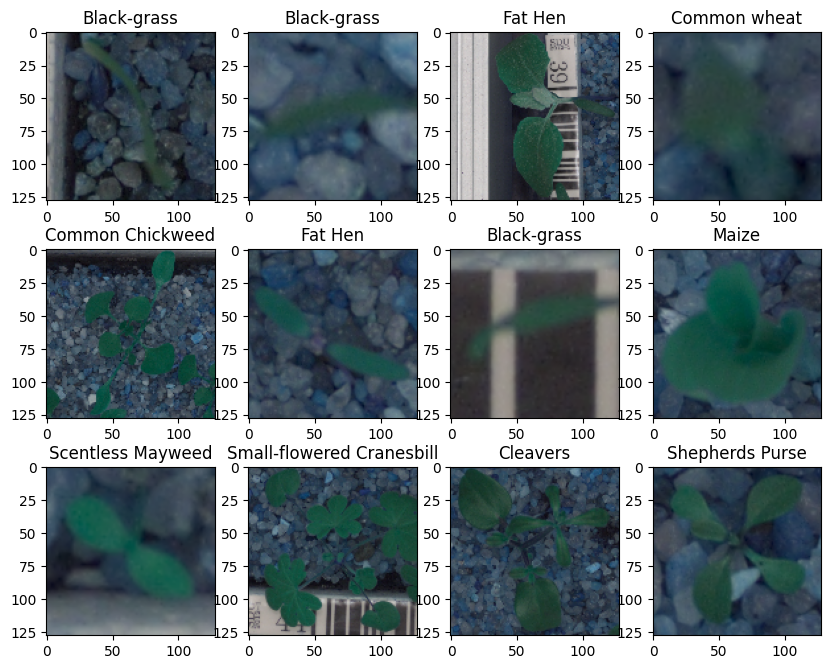

In [5]:
plot_images(images,labels)



*   The Shapes are different
*   The widths are different
*   The number of petals differ



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

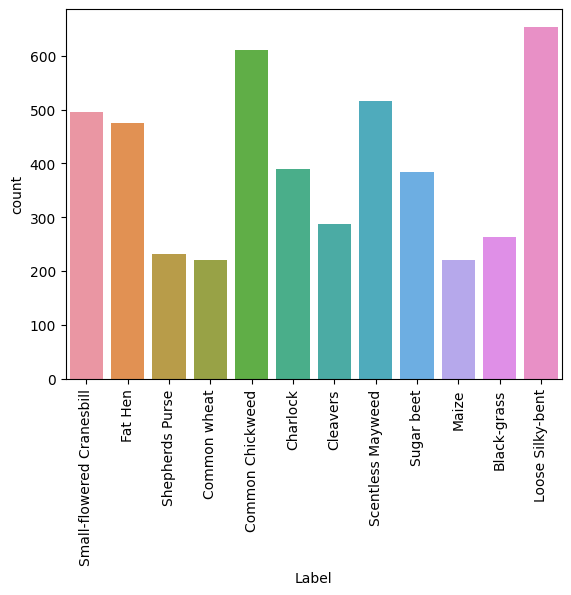

In [6]:
# Checking target variable distribution
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')



*   Varying Counts for different classes
*   Suggesting their is an imbalance in the number of images available for each
*   Over 600 Loose Silky-bent



In [7]:
# Initialize lists to store image heights, widths and pixel values
heights, widths, pixel_values = [], [], []

# Iterate over the images to gather statistics
for image in images:
    # Assuming that your images are grayscale or you're interested in the first channel only
    if image.ndim == 3:  # If images are colored (e.g., RGB)
        pixel_values.extend(image[:, :, 0].flatten())  # Take the pixel values of the first channel
        heights.append(image.shape[0])  # Image height
        widths.append(image.shape[1])  # Image width
    elif image.ndim == 2:  # If images are grayscale
        pixel_values.extend(image.flatten())
        heights.append(image.shape[0])
        widths.append(image.shape[1])

# Calculate basic statistics for heights and widths
avg_height = np.mean(heights)
std_height = np.std(heights)
avg_width = np.mean(widths)
std_width = np.std(widths)

# Print the statistics
print(f"Average height of images: {avg_height}")
print(f"Standard deviation of image heights: {std_height}")
print(f"Average width of images: {avg_width}")
print(f"Standard deviation of image widths: {std_width}")

Average height of images: 128.0
Standard deviation of image heights: 0.0
Average width of images: 128.0
Standard deviation of image widths: 0.0


Uniform Image Size: The average height and width of the images are both 128 pixels with a standard deviation of 0. This indicates that all images in the dataset are of the same size, suggesting a pre-processed dataset where image resizing to a uniform dimension has likely occurred.

Ease of Model Input Configuration: Since all the images have identical dimensions, it simplifies the configuration of input layers for machine learning models, particularly convolutional neural networks (CNNs), which require uniform input dimensions.

No Outliers in Size: The absence of variation in image dimensions (standard deviation of 0) means there are no outliers in terms of image size. This can often lead to more stable model training because the model doesn’t need to learn from or adjust to varying input sizes.

In [8]:
# Calculate basic statistics for pixel values
avg_pixel_value = np.mean(pixel_values)
std_pixel_value = np.std(pixel_values)

# Print the statistics
print(f"Average pixel value: {avg_pixel_value}")
print(f"Standard deviation of pixel values: {std_pixel_value}")

Average pixel value: 52.74117097553454
Standard deviation of pixel values: 32.55663285660254


Predominantly Dark Images: With an average pixel value of approximately 52.74 on a scale where 0 is black and 255 is white, the images in the dataset are generally dark. This could suggest that many of the images have a darker background or the subjects themselves are darker in color.

Moderate Contrast: A standard deviation of around 32.56 indicates a moderate level of contrast within the images. There is some variability in pixel brightness, but it is not extreme. This suggests that while there is some diversity in the pixel values, the images are neither very uniform nor highly contrasted.

Potential Preprocessing Requirement: Given that the pixel values are on the lower side of the spectrum and the moderate standard deviation, it may be beneficial to apply preprocessing techniques such as contrast normalization or histogram equalization to enhance the images before feeding them into a machine learning model.

In [9]:
# Detect anomalies/outliers - here we use z-score as an example
z_scores = np.abs((np.array(heights) - avg_height) / std_height)
outliers_height = np.where(z_scores > 3)  # Index of outliers which are beyond 3 standard deviations

z_scores = np.abs((np.array(widths) - avg_width) / std_width)
outliers_width = np.where(z_scores > 3)

# Print information about outliers
print(f"Outlier indices for heights: {outliers_height}")
print(f"Outlier indices for widths: {outliers_width}")

Outlier indices for heights: (array([], dtype=int64),)
Outlier indices for widths: (array([], dtype=int64),)


Consistent Image Dimensions: No outliers were detected in the image heights and widths, reinforcing the consistency in image dimensions across the dataset.

Standardized Dataset: The dataset appears to be standardized, with all images conforming to a specific size requirement, which is beneficial for batch processing in machine learning algorithms.

Preprocessing Effectiveness: The lack of outliers suggests that any preprocessing steps taken to normalize image dimensions have been effective across the entire dataset.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [10]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [11]:
images_decreased=[]
height = 64                    # Define the height as 64
width = 64                     # Define the width as 64
dimensions = (width, height)

for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))


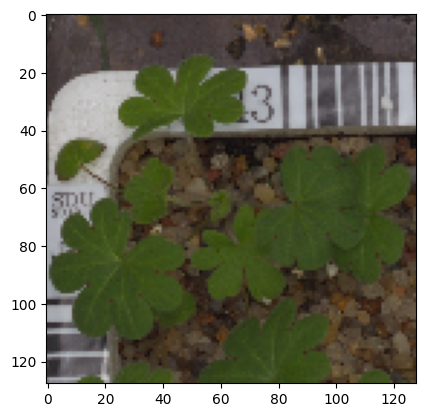

In [12]:
# Pre resize image
plt.imshow(images[3])

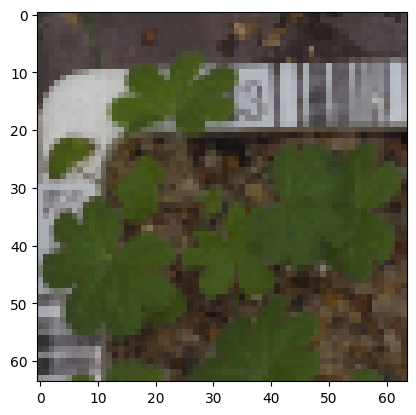

In [13]:
# Post resize image
plt.imshow(images_decreased[3])


### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [14]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp)

In [15]:
# Printing the shapes of the datasets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [16]:
# Initialize the LabelBinarizer
enc = LabelBinarizer()

# Fit and transform y_train, then transform y_val and y_test
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

In [17]:
# Checking the shapes of the encoded datasets
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization

In [18]:
# Normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0


## Model Building

In [19]:
# Clearing backend
backend.clear_session()

In [20]:
# Fix the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [21]:
# Initializing a sequential model
model1 = Sequential()

# Adding the first conv layer
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Adding two similar convolution and max-pooling layers with activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Flattening the output
model1.add(Flatten())

# Adding a fully connected dense layer
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

# Adding the output layer
model1.add(Dense(12, activation='softmax'))

# Using the Adam Optimizer and compiling the model
opt = Adam()
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [22]:
# Fitting the model on train data
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized, y_val_encoded),
            batch_size=32,
            verbose=2
)


Epoch 1/30
121/121 - 6s - loss: 2.4505 - accuracy: 0.1170 - val_loss: 2.4156 - val_accuracy: 0.2243 - 6s/epoch - 53ms/step
Epoch 2/30
121/121 - 1s - loss: 2.2371 - accuracy: 0.2469 - val_loss: 1.9807 - val_accuracy: 0.3505 - 1s/epoch - 11ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0084 - accuracy: 0.3028 - val_loss: 1.7637 - val_accuracy: 0.4042 - 1s/epoch - 10ms/step
Epoch 4/30
121/121 - 1s - loss: 1.8771 - accuracy: 0.3351 - val_loss: 1.6933 - val_accuracy: 0.4369 - 1s/epoch - 10ms/step
Epoch 5/30
121/121 - 1s - loss: 1.7635 - accuracy: 0.3665 - val_loss: 1.5517 - val_accuracy: 0.4930 - 1s/epoch - 9ms/step
Epoch 6/30
121/121 - 1s - loss: 1.6584 - accuracy: 0.3928 - val_loss: 1.4464 - val_accuracy: 0.5093 - 1s/epoch - 9ms/step
Epoch 7/30
121/121 - 1s - loss: 1.6455 - accuracy: 0.4107 - val_loss: 1.3983 - val_accuracy: 0.5164 - 1s/epoch - 9ms/step
Epoch 8/30
121/121 - 1s - loss: 1.5525 - accuracy: 0.4271 - val_loss: 1.2745 - val_accuracy: 0.5561 - 1s/epoch - 9ms/step
Epoch 9/30
121/121 -

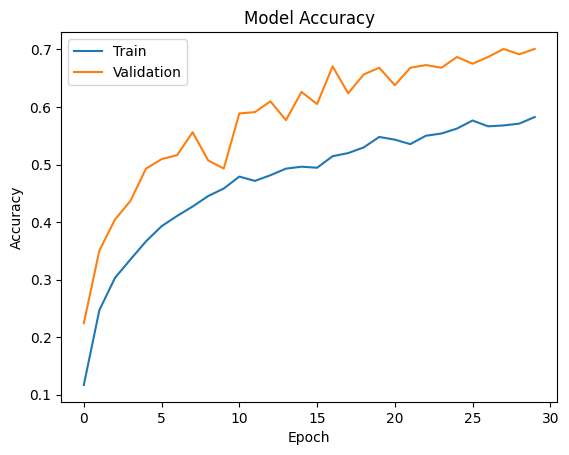

15/15 - 0s - loss: 1.0636 - accuracy: 0.6589 - 270ms/epoch - 18ms/step


In [23]:
#Model Evaluation

# Plotting the accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on test data
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)


15/15 [==============================] - 0s 3ms/step


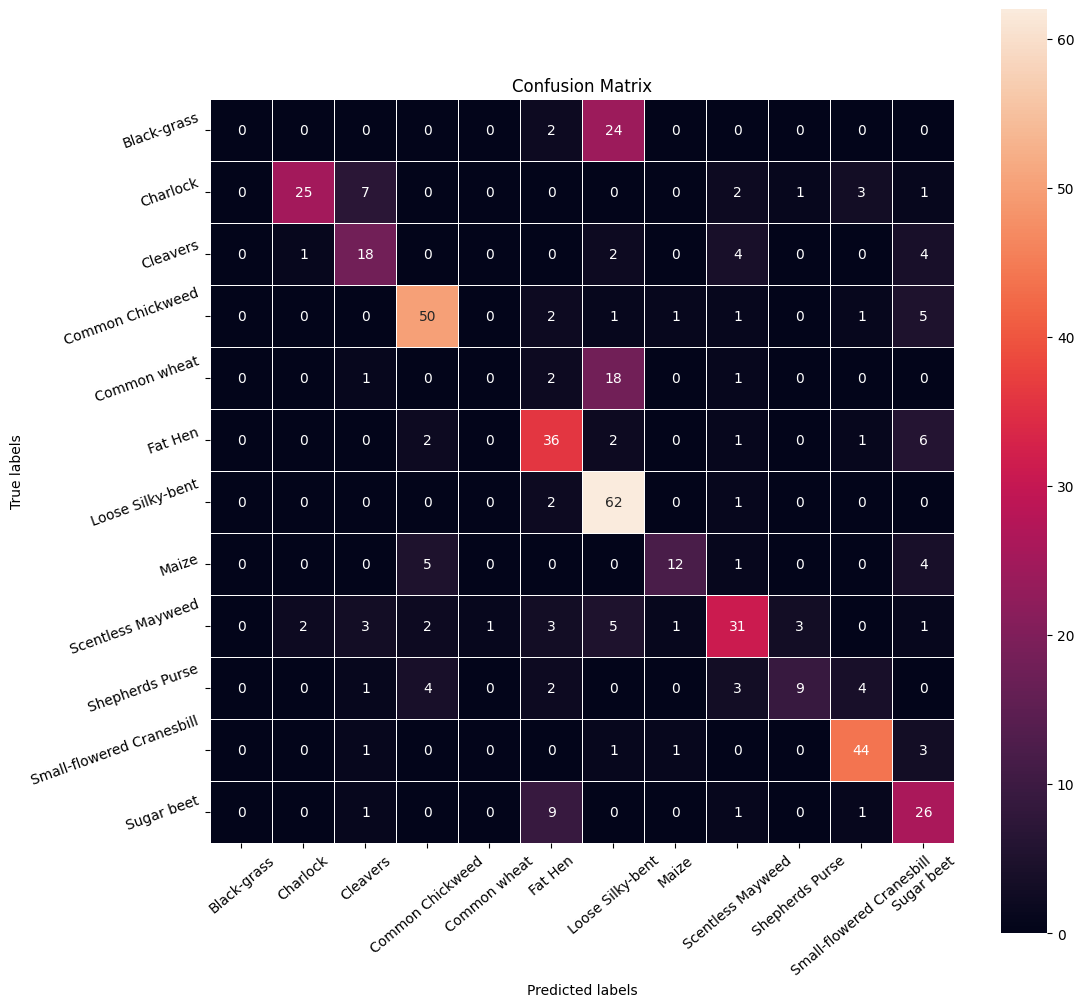

In [24]:
# Plotting the Confusion Matrix

# Predicting the output probabilities
y_pred = model1.predict(X_test_normalized)

# Obtaining the categorical values
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting labels
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_), rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_), rotation=20)
plt.show()


In [25]:
from sklearn.metrics import classification_report


# Plot the classification report
cr = classification_report(y_test_arg, y_pred_arg)
print(cr)



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.89      0.64      0.75        39
           2       0.56      0.62      0.59        29
           3       0.79      0.82      0.81        61
           4       0.00      0.00      0.00        22
           5       0.62      0.75      0.68        48
           6       0.54      0.95      0.69        65
           7       0.80      0.55      0.65        22
           8       0.67      0.60      0.63        52
           9       0.69      0.39      0.50        23
          10       0.81      0.88      0.85        50
          11       0.52      0.68      0.59        38

    accuracy                           0.66       475
   macro avg       0.58      0.57      0.56       475
weighted avg       0.62      0.66      0.62       475



## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [26]:
# Monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [27]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fix the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [28]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [29]:
# Initializing a sequential model
model2 = Sequential()

# Adding the first conv layer
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# Flattening the output
model2.add(Flatten())

# Adding a dense layer
model2.add(Dense(16, activation='relu'))

# Adding dropout
model2.add(Dropout(0.3))

# Adding the output layer
model2.add(Dense(12, activation='softmax'))

# Initializing Adam Optimizer
opt = Adam()

# Compiling the model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [30]:
# Fitting the model on training data

# Epochs and Batch size
epochs = 30
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized, y_val_encoded),
                                       verbose=1, callbacks=[learning_rate_reduction])


Epoch 1/30
60/60 [==============================] - 8s 89ms/step - loss: 2.1399 - accuracy: 0.2450 - val_loss: 2.3858 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 85ms/step - loss: 1.6670 - accuracy: 0.4192 - val_loss: 2.2893 - val_accuracy: 0.1916 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 6s 99ms/step - loss: 1.4660 - accuracy: 0.4859 - val_loss: 2.2390 - val_accuracy: 0.3575 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 6s 101ms/step - loss: 1.3562 - accuracy: 0.5136 - val_loss: 2.0503 - val_accuracy: 0.3738 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 5s 75ms/step - loss: 1.2520 - accuracy: 0.5546 - val_loss: 1.8141 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 5s 76ms/step - loss: 1.1533 - accuracy: 0.5863 - val_loss: 1.5820 - val_accuracy: 0.5654 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 7s 112ms/step - loss: 1

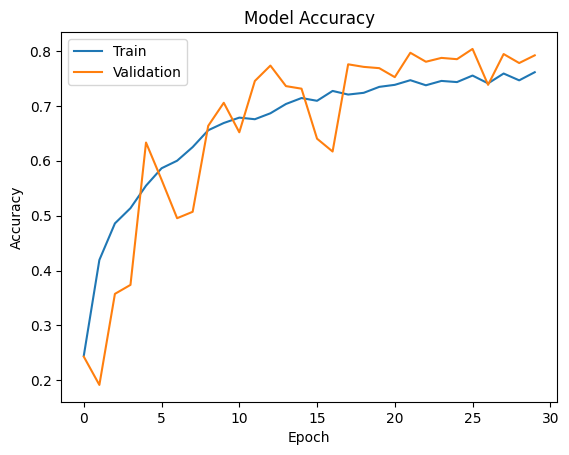

15/15 - 0s - loss: 0.7074 - accuracy: 0.7832 - 287ms/epoch - 19ms/step


In [31]:
# Model Evaluation

# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on test data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)


15/15 [==============================] - 0s 4ms/step


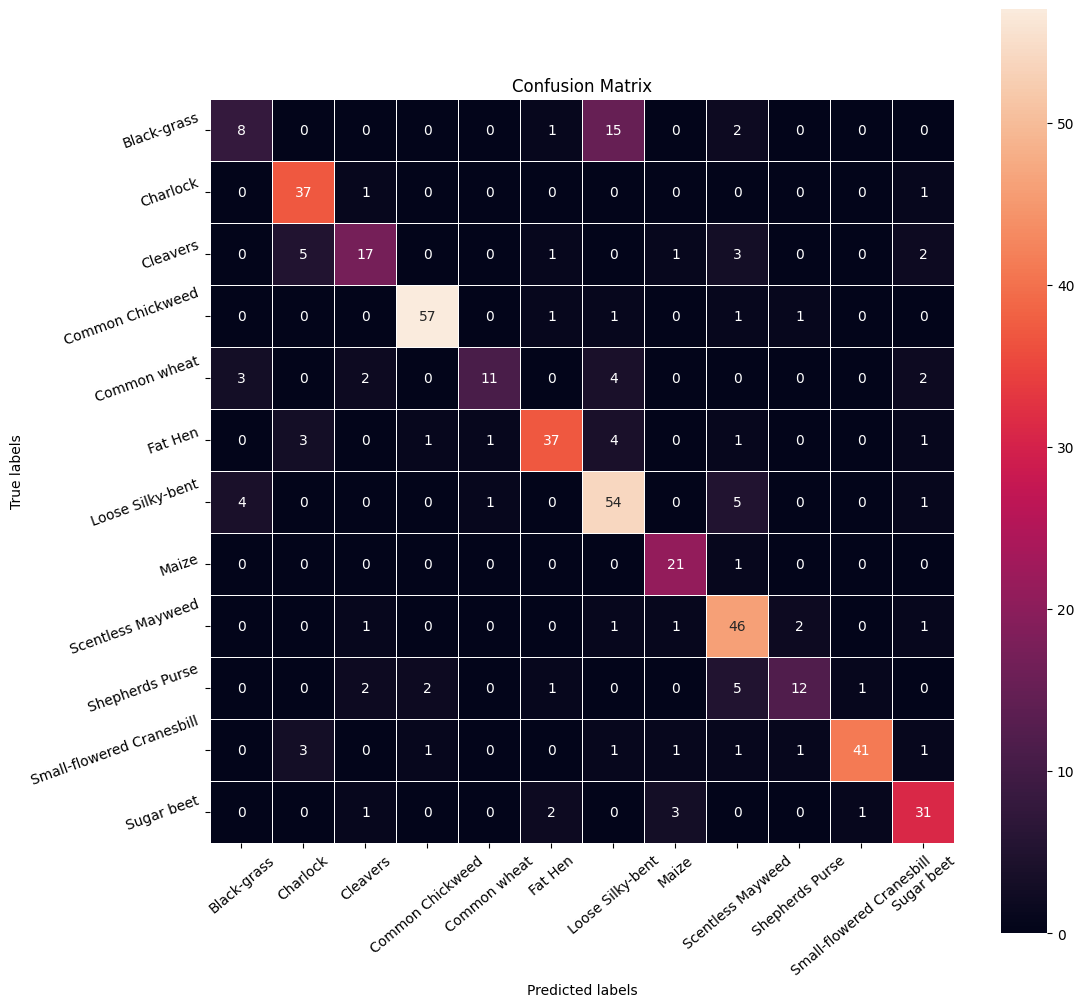

In [32]:
# Plotting confusion matrix

# Obtain the output probabilities
y_pred = model2.predict(X_test_normalized)

# Obtaining the categorical values
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)

# Setting labels
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_), rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_), rotation=20)
plt.show()


In [33]:
# Plot Classification Report

# Plot the classification report
cr = classification_report(y_test_arg, y_pred_arg)
print(cr)


              precision    recall  f1-score   support

           0       0.53      0.31      0.39        26
           1       0.77      0.95      0.85        39
           2       0.71      0.59      0.64        29
           3       0.93      0.93      0.93        61
           4       0.85      0.50      0.63        22
           5       0.86      0.77      0.81        48
           6       0.68      0.83      0.74        65
           7       0.78      0.95      0.86        22
           8       0.71      0.88      0.79        52
           9       0.75      0.52      0.62        23
          10       0.95      0.82      0.88        50
          11       0.78      0.82      0.79        38

    accuracy                           0.78       475
   macro avg       0.77      0.74      0.74       475
weighted avg       0.79      0.78      0.78       475



## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [34]:
#The final model is model2, which achieved the highest accuracy.
# The model recieved a 79% accuracy


### Visualizing the prediction

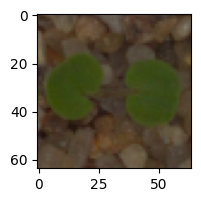

1/1 [==============================] - 0s 120ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


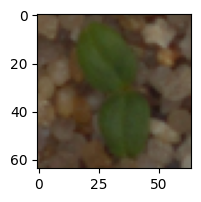

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Cleavers']
True Label Cleavers


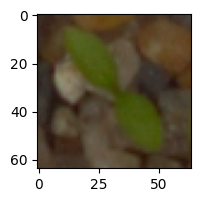

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


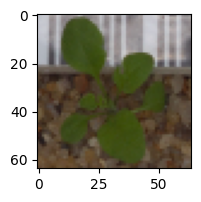

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [35]:
# Visualize the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[2].reshape(1,64,64,3))))
print('True Label', enc.inverse_transform(y_test_encoded.reshape(-1, 12))[2])

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[33].reshape(1,64,64,3))))
print('True Label', enc.inverse_transform(y_test_encoded.reshape(-1, 12))[33])

plt.figure(figsize=(2,2))
plt.imshow(X_test[59])
plt.show()
# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[59].reshape(1,64,64,3))))
print('True Label', enc.inverse_transform(y_test_encoded.reshape(-1, 12))[59])

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
# Predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[36].reshape(1,64,64,3))))
print('True Label', enc.inverse_transform(y_test_encoded.reshape(-1, 12))[36])


## Actionable Insights and Business Recommendations

* You can use AI classifier to determine the plants species from an image with 79% accuracy
* This can help you be more efficient and effective
* There may still be room for improvement with techniques like transfer learning.
* From a business perspective you can use this AI to improve your own business operations and maybe even try selling this as a service to other companies who could benefit.

_____